Yolov3 Demo

In [1]:
import torch
from sagemakercv.detection.detector import build_detection_model
from utils1 import (unarchive_data, 
                   get_training_world, 
                   is_sm, 
                   is_sm_dist, 
                   get_herring_world,
                   config_check)
from sagemakercv.training import make_optimizer, make_lr_scheduler
from sagemakercv.data import make_data_loader
from sagemakercv.data.utils import prefetcher
from sagemakercv.utils.checkpoint import DetectronCheckpointer
from sagemakercv.utils.runner import build_hooks, Runner
from sagemakercv.utils.runner.hooks.checkpoint import DetectronCheckpointHook
from sagemakercv.training.trainers import train_step
import apex
from configs import cfg
from tqdm.auto import tqdm
from statistics import mean

if (torch._C, '_jit_set_profiling_executor') :
    torch._C._jit_set_profiling_executor(False)
if (torch._C, '_jit_set_profiling_mode') :
    torch._C._jit_set_profiling_mode(False)
    

In [2]:
cfg.merge_from_file('configs/st_yolo_bs8.yaml')

In [3]:
#config_check(cfg)
cfg.freeze()

Load dataset - COCO

In [4]:
train_coco_loader, num_iterations = make_data_loader(cfg)

loading annotations into memory...
Done (t=15.59s)
creating index...
index created!


In [5]:
device = torch.device(cfg.MODEL.DEVICE)
train_iterator = prefetcher(iter(train_coco_loader), device)

[2021-08-03 07:14:44.305 smcv-pt-1-8-ml-p3-8xlarge-4e632c7d8fc57b8535f1324c7fed:6444 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-03 07:14:44.350 smcv-pt-1-8-ml-p3-8xlarge-4e632c7d8fc57b8535f1324c7fed:6444 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Build model
Backbone: Darknet 53
Neck: Yolov3

In [6]:
# import sys
# sys.path.append('../')
from sagemakercv.detection.backbone.darknet import build_darknet_backbone
backbone = build_darknet_backbone(cfg)

In [7]:
from detection.dense_heads.yolo_head import build_yolo_head
model = build_yolo_head(cfg)

In [8]:
# backbone

In [9]:
# model

Load weights and Training

In [10]:
# backbone_weights = torch.load('/home/sagemaker-user/data/weights/epoch_60.ph')

In [11]:
# backbone_weights = {i.replace('module.', ''):j for i,j in backbone_weights.items() if not i.startswith('module.fc.')}

In [12]:
import torch.nn as nn
class Yolov3Detector(nn.Module):
    def __init__(self, backbone, model, cfg):
        super(Yolov3Detector, self).__init__()
        self.num_classes = cfg.MODEL.YOLO.CLASSES
        self.backbone = backbone
        self.model = model #yolo head
    
    def forward(self, images, targets = None):
#         print(image)
#         print(image.tensor)
        fpn_outputs = self.backbone(images.tensors)
        pred_maps = self.model(fpn_outputs)
        if targets:
            losses, parsed_targets = self.model.loss(images, pred_maps, targets)
            return losses, parsed_targets, pred_maps
        return pred_maps
    
def yolov3_model(backbone, model, cfg):
    return Yolov3Detector(backbone, model, cfg)

In [13]:
model_train = yolov3_model(backbone, model, cfg)

In [14]:
# model_train.backbone.backbone.load_state_dict(backbone_weights)
# for param in model_train.backbone.backbone.parameters():
#     param.requires_grad = False

In [14]:
model_train = model_train.to(device)
optimizer = torch.optim.Adam(model_train.parameters())
scheduler = make_lr_scheduler(cfg, optimizer)
losses, parsed_targets, pred_maps = model_train(*next(train_iterator))

In [15]:
import torch
import apex

def train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, pred_maps = model(images, targets)
    #optimizer.backward(losses['total_loss']) 
    losses['total_loss'].backward()
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    return losses

In [16]:
images, targets = next(train_iterator)
train_step(images, targets, model_train, optimizer, scheduler, device)

{'xy_loss': tensor(1.3859, device='cuda:0', grad_fn=<SumBackward0>),
 'wh_loss': tensor(5.3892, device='cuda:0', grad_fn=<SumBackward0>),
 'obj_loss': tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'class_loss': tensor(4.3994, device='cuda:0', grad_fn=<DivBackward0>),
 'total_loss': tensor(11.8529, device='cuda:0', grad_fn=<AddBackward0>)}

In [17]:
def train_epoch(data_iterator, steps, log=True, log_interval=50):
    model_train.train()
    for i in range(steps):
        images, targets = next(data_iterator)
        loss_dict = train_step(images, targets, model_train, optimizer, scheduler, device)
        if log and i%log_interval==0:
            print(f"Step {i}, Loss: {float(loss_dict['total_loss'])}, LR: {scheduler.get_lr()[0]}")

In [18]:
# train_epoch(train_iterator, 500)

In [19]:
loss_dict = train_step(images, targets, model_train, optimizer, scheduler, device)
loss_dict

{'xy_loss': tensor(0.9429, device='cuda:0', grad_fn=<SumBackward0>),
 'wh_loss': tensor(1.6685, device='cuda:0', grad_fn=<SumBackward0>),
 'obj_loss': tensor(0.6208, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'class_loss': tensor(4.1484, device='cuda:0', grad_fn=<DivBackward0>),
 'total_loss': tensor(7.3806, device='cuda:0', grad_fn=<AddBackward0>)}

In [20]:

print(losses['weighted_total_loss'])
print(losses['total_loss'])


KeyError: 'weighted_total_loss'

In [ ]:
#set device
torch.cuda.set_device(0)
# torch.cuda.set_device(1)
print(torch.cuda.current_device())
device = torch.device(cfg.MODEL.DEVICE)

#batch size
# cfg.
cfg.SOLVER.IMS_PER_BATCH = 8

# freeze different layers
backbone_weights = torch.load('/home/sagemaker-user/data/weights/epoch_60.ph')
backbone_weights = {i.replace('module.', ''):j for i,j in backbone_weights.items() if not i.startswith('module.fc.')}
model_train.backbone.backbone.load_state_dict(backbone_weights)
freeeze = set()
#certain layers to freeze
for param in model_train.backbone.backbone.parameters():
    if param in freeze:
        param.requires_grad = False
        
#set optimizer, revise learning rate
model_train = model_train.to(device)
optimizer = torch.optim.Adam(model_train.parameters())
scheduler = make_lr_scheduler(cfg, optimizer)
losses, parsed_targets, pred_maps = model_train(*next(train_iterator))

# revise learning rate
cfg.SOLVER.BASE_LR = 0.1 # max lr or base lr init_lr
        
#revise loss function (now: add everything up)
def train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, pred_maps = model(images, targets)
#     losses['total_loss'].backward()
    lambda_xy, lambda_wh, lambda_obj, lambda_cls = 1, 1, 1, 0.5 #set weights
    losses['weighted_total_loss'] = lambda_xy*losses['xy_loss'] + lambda_wh*losses['wh_loss'] + lambda_obj*losses['obj_loss'] + lambda_cls*losses['class_loss']
    losses['weighted_total_loss'].backward()
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    return losses

def train_epoch(data_iterator, steps, log=True, log_interval=50):
    model_train.train()
    for i in range(steps):
        images, targets = next(data_iterator)
        loss_dict = train_step(images, targets, model_train, optimizer, scheduler, device)
        if log and i%log_interval==0:
            print(f"Step {i}, Loss: {float(loss_dict['total_loss'])}, LR: {scheduler.get_lr()[0]}")


In [70]:
train_epoch(train_iterator, 500)

Step 0, Loss: 60.54148864746094, LR: 0.000140734
Step 50, Loss: 14.15224838256836, LR: 0.000527434


KeyboardInterrupt: 

In [17]:
from apex.parallel import DistributedDataParallel as DDP
from apex import amp

#set device
torch.cuda.set_device(0)
# torch.cuda.set_device(1)
print(torch.cuda.current_device())
device = torch.device(cfg.MODEL.DEVICE)

#batch size
# cfg.
# cfg.SOLVER.IMS_PER_BATCH = 8

# freeze different layers
# backbone_weights = torch.load('/home/sagemaker-user/data/weights/epoch_60.ph')
# backbone_weights = {i.replace('module.', ''):j for i,j in backbone_weights.items() if not i.startswith('module.fc.')}
# model_train.backbone.backbone.load_state_dict(backbone_weights)
# freeeze = set()
# #certain layers to freeze
# for param in model_train.backbone.backbone.parameters():
#     if param in freeze:
#         param.requires_grad = False
        
#set optimizer, revise learning rate
model_train = model_train.to(device)
optimizer = torch.optim.SGD(model_train.parameters(), lr = 0.001)
scheduler = make_lr_scheduler(cfg, optimizer)
losses, parsed_targets, pred_maps = model_train(*next(train_iterator))
model_train, optimizer = amp.initialize(model_train, optimizer, 
                                      opt_level='O1')
# model_train = DDP(model_train)

# revise learning rate
cfg.SOLVER.BASE_LR = 0.001 # max lr or base lr init_lr
# change lr by batch size
# lr = 0.001;
# policy=steps
# steps=400000,450000
# scales=.1,.1
        
#revise loss function (now: add everything up)
def train_step(images, targets, model, optimizer, scheduler, device, grad_clip=0.0):
    optimizer.zero_grad()
    losses, parsed_targets, pred_maps = model(images, targets)
    
    lambda_xy, lambda_wh, lambda_obj, lambda_cls = 1, 1, 1, 0.5 #set weights
    losses['weighted_total_loss'] = lambda_xy*losses['xy_loss'] + lambda_wh*losses['wh_loss'] + lambda_obj*losses['obj_loss'] + lambda_cls*losses['class_loss']
    
    # use mixed percision
#     losses['weighted_total_loss'].backward()
    with apex.amp.scale_loss(losses['weighted_total_loss'], optimizer) as scaled_loss:
            scaled_loss.backward()
            
            
    if grad_clip>0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()
    return losses

def train_epoch(data_iterator, steps, log=True, log_interval=50):
    # add apex
    model_train.train()
    
    for i in range(steps):
        images, targets = next(data_iterator)
        loss_dict = train_step(images, targets, model_train, optimizer, scheduler, device)
        if log and i%log_interval==0:
            print(f"Step {i}, Loss: {float(loss_dict['total_loss'])}, LR: {scheduler.get_lr()[0]}")
#             print(loss_dict)
            print(f"Loss dict: Loss dict: {float(loss_dict['weighted_total_loss'])}, xy_loss: {float(loss_dict['xy_loss'])}, wh_loss: {float(loss_dict['wh_loss'])}, obj_loss: {float(loss_dict['obj_loss'])}, class_loss: {float(loss_dict['class_loss'])}")


0
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [19]:
train_epoch(train_iterator, 5000)

Step 0, Loss: 10.848748207092285, LR: 0.0009999999993047857
Loss dict: Loss dict: 8.912059783935547, xy_loss: 3.949394941329956, wh_loss: 2.8318703174591064, obj_loss: 0.19410587847232819, class_loss: 3.8733768463134766
Step 50, Loss: 12.547074317932129, LR: 0.000999998191748572
Loss dict: Loss dict: 10.354654312133789, xy_loss: 3.6712560653686523, wh_loss: 4.2974700927734375, obj_loss: 0.1935080587863922, class_loss: 4.38484001159668
Step 100, Loss: 12.108453750610352, LR: 0.0009999929081352373
Loss dict: Loss dict: 10.018060684204102, xy_loss: 3.586378574371338, wh_loss: 4.201342582702637, obj_loss: 0.1399475485086441, class_loss: 4.180785179138184
Step 150, Loss: 11.565740585327148, LR: 0.0009999841485016057
Loss dict: Loss dict: 9.74799633026123, xy_loss: 4.421257972717285, wh_loss: 3.364755630493164, obj_loss: 0.14423857629299164, class_loss: 3.635488271713257
Step 200, Loss: 12.544273376464844, LR: 0.000999971912908728
Loss dict: Loss dict: 10.117838859558105, xy_loss: 3.57330322

In [ ]:
hyp = {'giou': 3.54,  # giou loss gain
       'cls': 37.4,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 49.5,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.225,  # iou training threshold
       'lr0': 0.00579,  # initial learning rate (SGD=1E-3, Adam=9E-5)
       'lrf': -4.,  # final LambdaLR learning rate = lr0 * (10 ** lrf)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 0.000484,  # optimizer weight decay
       'fl_gamma': 0.5,  # focal loss gamma
       'hsv_h': 0.0138,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.678,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 1.98,  # image rotation (+/- deg)
       'translate': 0.05,  # image translation (+/- fraction)
       'scale': 0.05,  # image scale (+/- gain)
       'shear': 0.641}  # image shear (+/- deg)
# parameters from train.py

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
import colorsys
import random

def evaluate(images, model):
    model.eval()
    results_dict = {}
    images = images.to(device)
    cpu_device = torch.device("cpu")
    with torch.no_grad():
        output = model(images)
        output = [o.to(cpu_device) for o in output]
    model.train()
    return output

def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def restore_image(image, 
                  cfg):
    image = image.to(torch.device("cpu"))
    image = (torch.transpose(image, 0, -1) + torch.tensor(cfg.INPUT.PIXEL_MEAN))/255.
    image = np.flip(np.array(image), 2)
    return image

def add_boxes(boxlist, ax, threshold=0.75):
    for box, score in zip(boxlist.bbox, boxlist.extra_fields['scores']):
        y1, x1, y2, x2 = box
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed", edgecolor='r',
                              facecolor='none')
        if score>threshold:
            ax.add_patch(p)

def build_image(image, boxlist, cfg, figsize=(10, 10)):
    image = restore_image(image, cfg)
    fig, ax = plt.subplots(1, figsize=figsize)
    plt.imshow(image)
    add_boxes(boxlist, ax)
    

In [29]:
images, targets = next(train_iterator)

In [30]:
output = evaluate(images, model_train)

In [31]:
image = restore_image(images.tensors[2], cfg)

In [32]:
output[2].bbox.shape[0]

AttributeError: 'Tensor' object has no attribute 'bbox'

AttributeError: 'Tensor' object has no attribute 'bbox'

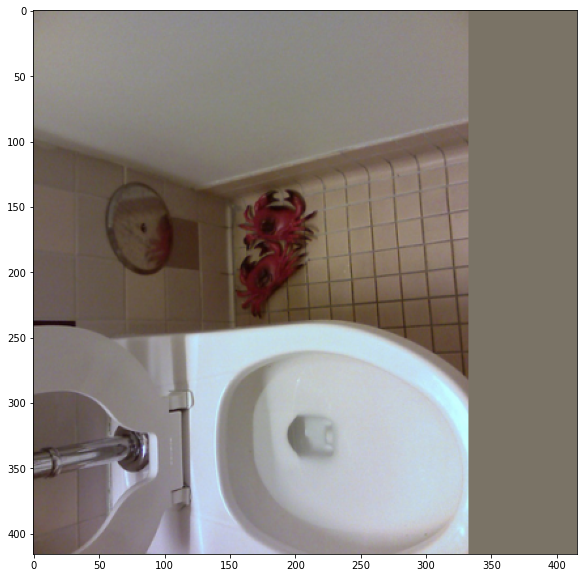

In [33]:
build_image(images.tensors[0], output[0], cfg)

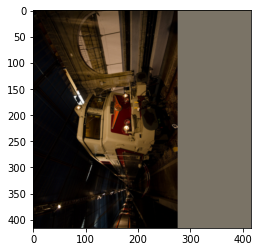

In [34]:
plt.imshow(image)

In [ ]:
detect_objects(model_train, image, )

In [39]:
def nms(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
        image_pred = image_pred[conf_mask]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1,  keepdim=True)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
        # Iterate through all predicted classes
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
        for c in unique_labels:
            # Get the detections with the particular class
            detections_class = detections[detections[:, -1] == c]
            # Sort the detections by maximum objectness confidence
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # Perform non-maximum suppression
            max_detections = []
            while detections_class.size(0):
                # Get detection with highest confidence and save as max detection
                max_detections.append(detections_class[0].unsqueeze(0))
                # Stop if we're at the last detection
                if len(detections_class) == 1:
                    break
                # Get the IOUs for all boxes with lower confidence
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                # Remove detections with IoU >= NMS threshold
                detections_class = detections_class[1:][ious < nms_thres]

            max_detections = torch.cat(max_detections).data
            # Add max detections to outputs
            output[image_i] = max_detections if output[image_i] is None else torch.cat((output[image_i], max_detections))

    return output


#to draw on image
def detect_objects(model, img):
    
    # Set the model to evaluation mode.
    model.eval()
    
    # Convert the image from a NumPy ndarray to a PyTorch Tensor of the correct shape.
    # The image is transposed, then converted to a FloatTensor of dtype float32, then
    # Normalized to values between 0 and 1, and finally unsqueezed to have the correct
    # shape of 1 x 3 x 416 x 416
    img = torch.from_numpy(img.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # Feed the image to the neural network with the corresponding NMS threshold.
    # The first step in NMS is to remove all bounding boxes that have a very low
    # probability of detection. All predicted bounding boxes with a value less than
    # the given NMS threshold will be removed.
    list_boxes = model(img)
    
    # Make a new list with all the bounding boxes returned by the neural network
    boxes = list_boxes[0][0] + list_boxes[1][0] + list_boxes[2][0]
    
    # Perform the second step of NMS on the bounding boxes returned by the neural network.
    # In this step, we only keep the best bounding boxes by eliminating all the bounding boxes
    # whose IOU value is higher than the given IOU threshold
    boxes = nms(boxes, 80)
    
    
    # Print the time it took to detect objects
    print('\n\nIt took {:.3f}'.format(finish - start), 'seconds to detect the objects in the image.\n')
    
    # Print the number of objects detected
    print('Number of Objects Detected:', len(boxes), '\n')
    
    return boxes

In [40]:
detect_objects(model_train, image)

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 